In [103]:
import kagglehub
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import numpy as np
from scipy import ndimage
from skimage.transform import resize
import pandas as pd
from sklearn.model_selection import train_test_split


In [104]:
path = kagglehub.dataset_download("tomasfern/oxford-iit-pets")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\LG\.cache\kagglehub\datasets\tomasfern\oxford-iit-pets\versions\1


In [105]:
from os import listdir
from os.path import isfile, join

base_path = Path(path)
images_path = base_path / "images" / "images"
annotations_path = base_path / "annotations"/ "annotations"

xml_path = annotations_path  / "xmls"
samples_name = [Path(f).stem for f in listdir(xml_path) if isfile(join(xml_path, f))]

In [106]:
def load_sample(file_name):

    img1_path = images_path  / f"{file_name}.jpg"
    img2_path = annotations_path  / "trimaps" / f"{file_name}.png"
    xml_path = annotations_path  / "xmls" / f"{file_name}.xml"

    image = np.asarray(Image.open(img1_path))
    mask = np.asarray(Image.open(img2_path))

    with open(xml_path, 'r') as f:
        data = f.read()
        
    data = BeautifulSoup(data, "xml")
    info = {k : int(data.find(k).text) for k in ['xmin','xmax','ymin','ymax','width','height']}

    return {'image': image, 'mask': mask, 'info': info}

samples = {f:load_sample(f) for f in samples_name}

# Data exploration

C:\Users\LG\Desktop\TEMP\ipykernel_20884\2595530351.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


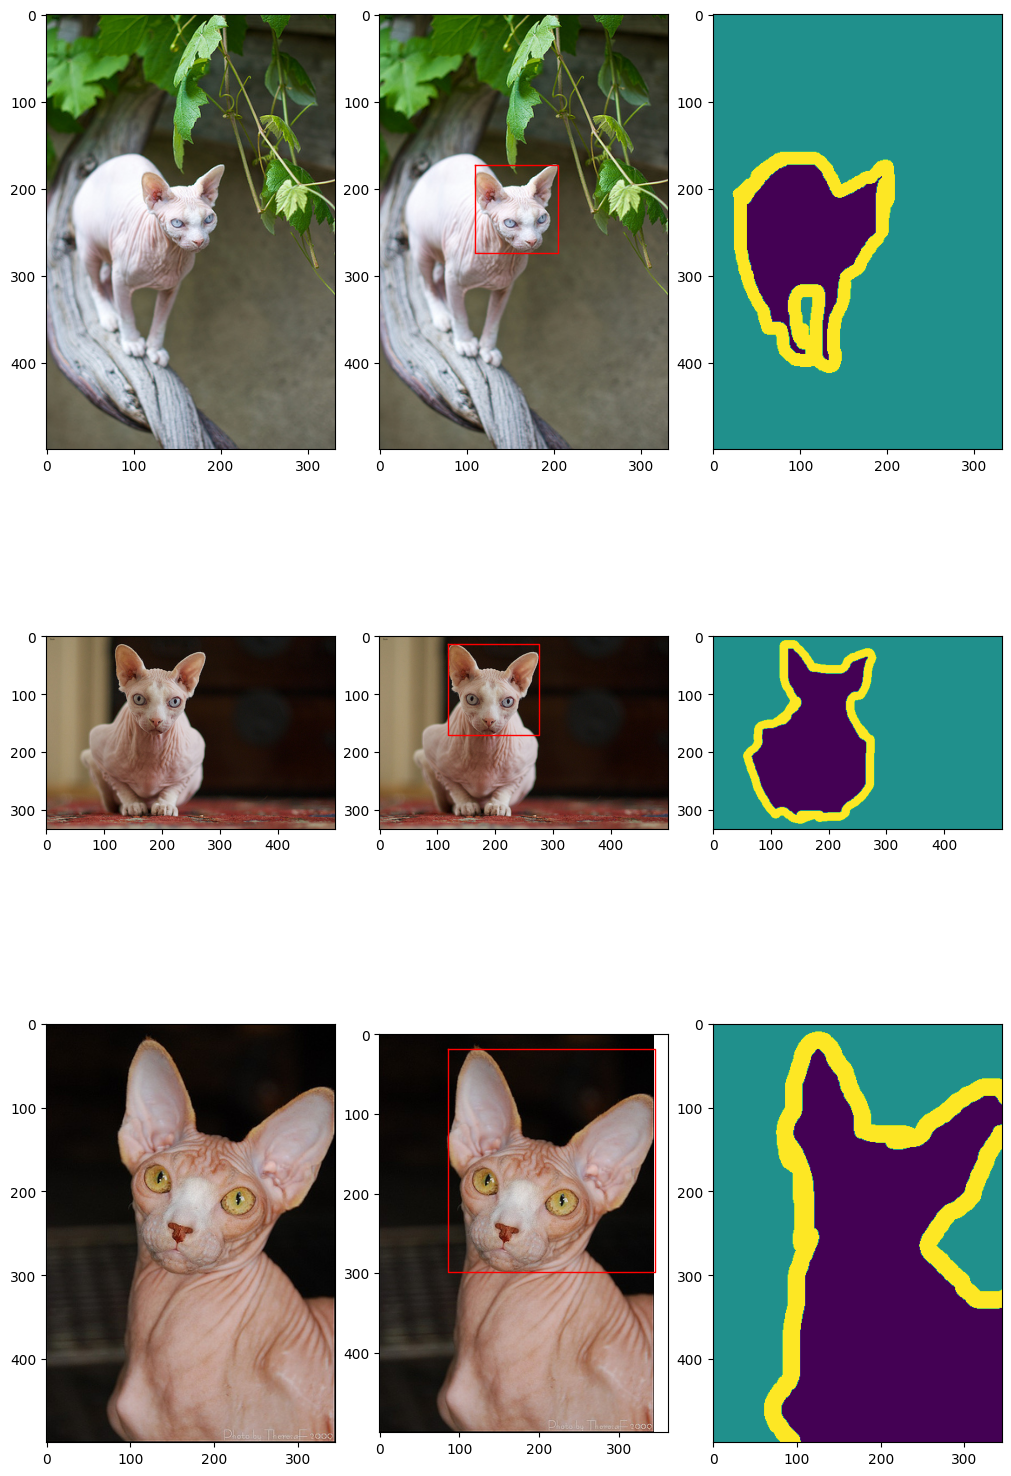

In [107]:
def show_samples(files):

    fig, axes = plt.subplots(ncols=3, nrows=len(files), figsize=(10, 5*len(files)),
                        layout="constrained")

    if len(files) == 1:
        sample = samples[files[0]]

        data = sample['info']
        
        axes[0].imshow(sample['image'])
        axes[1].imshow(sample['image'])

        x = [data['xmin'], data['xmin'], data['xmax'], data['xmax'], data['xmin']]
        y = [data['ymin'], data['ymax'], data['ymax'], data['ymin'], data['ymin']]

        axes[1].plot(x, y, color="red", linewidth=1)

        axes[2].imshow(sample['mask'])
        return
    
    for i, file_name in enumerate(files):


        sample = samples[file_name]

        data = sample['info']
        
        axes[i, 0].imshow(sample['image'])
        axes[i, 1].imshow(sample['image'])

        x = [data['xmin'], data['xmin'], data['xmax'], data['xmax'], data['xmin']]
        y = [data['ymin'], data['ymax'], data['ymax'], data['ymin'], data['ymin']]

        axes[i, 1].plot(x, y, color="red", linewidth=1)

        axes[i, 2].imshow(sample['mask'])

    fig.show()

files = [f"Sphynx_20{i}" for i in [3,5,6]]
show_samples(files)


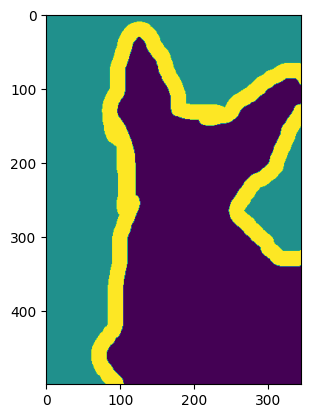

Background - 2
Object - 1
border - 3


In [108]:
mask = samples["Sphynx_206"]["mask"]
plt.imshow(mask)
plt.show()
print("Background - " + str(mask[0][0]))

print("Object - " + str(mask[mask.shape[0]-1][mask.shape[1]-1]))
print("border - " + str(mask[mask.shape[0]-1][100]))

In [109]:
print(samples_name[0:10])
print(len(samples_name))

['Abyssinian_1', 'Abyssinian_10', 'Abyssinian_100', 'Abyssinian_101', 'Abyssinian_102', 'Abyssinian_103', 'Abyssinian_105', 'Abyssinian_106', 'Abyssinian_107', 'Abyssinian_108']
3686


C:\Users\LG\Desktop\TEMP\ipykernel_20884\373245745.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


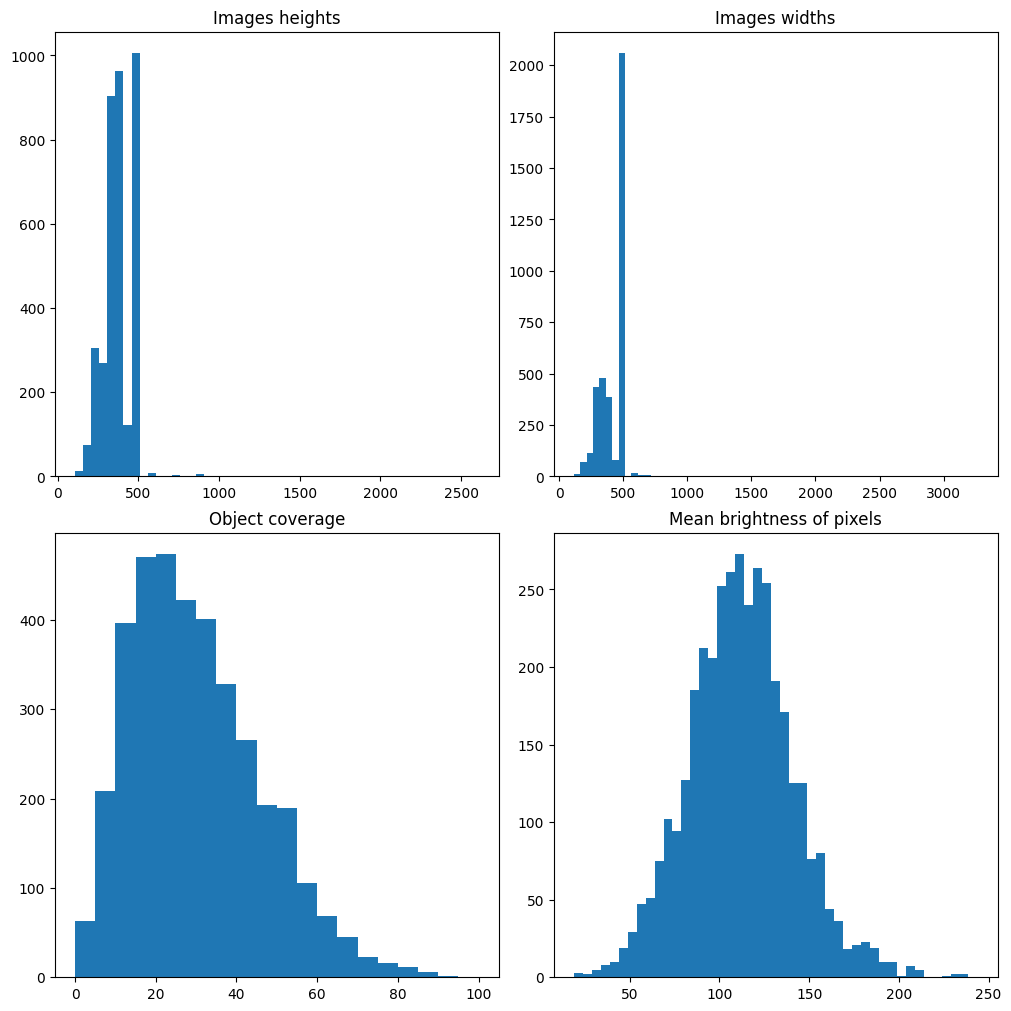

In [110]:
def plot_histogram(plot, title, data, step = 50):
    bins = np.arange(min(data), max(data) + 10, step)
    plot.hist(data, bins=bins)
    plot.set_title(title)

heights = [value['info']['height'] for value in samples.values()]
widths = [value['info']['width'] for value in samples.values()]
coverages = [(np.sum(s['mask'] == 1) / (s['info']['height'] * s['info']['width'])) * 100 for s in samples.values()]
br = [np.mean(v['image']) for v in samples.values()]

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10),
                        layout="constrained")

plot_histogram(axes[0,0], "Images heights", heights)
plot_histogram(axes[0,1],"Images widths", widths)
plot_histogram(axes[1,0],"Object coverage", coverages, step = 5)
plot_histogram(axes[1,1],"Mean brightness of pixels", br, step = 5)

fig.show()

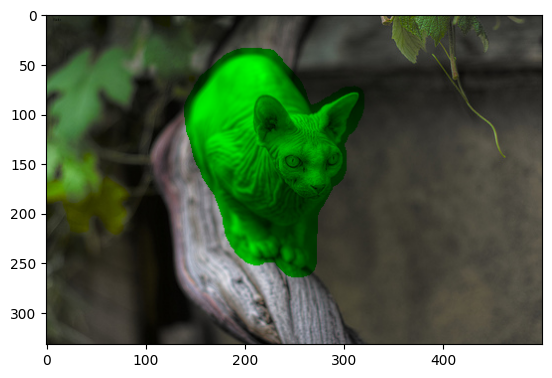

In [111]:
# irrelevant at this point, but makes a car green

def turn_green(image, mask):
    

    mask_indices = np.isin(mask, [1, 3])

    image = image.copy()

    
    image[mask_indices, 0] = 0
    image[mask_indices, 2] = 0

    return image

    

sample = load_sample("Sphynx_202")
mask = sample["mask"]
image = sample["image"].copy()

green_image = turn_green(image, mask)
plt.imshow(green_image)
plt.show()

# Data preparation



Mask is simplified to include only two classes. Border pixels are changed to object or background, based on their distance to the nearast object or background pixel.

C:\Users\LG\Desktop\TEMP\ipykernel_20884\1310678163.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


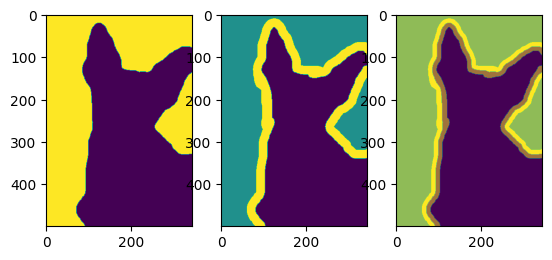

In [112]:
def simplify_mask(mask):
    object_mask = (mask == 1)
    background_mask = (mask == 2)

    distances_to_object = ndimage.distance_transform_edt(~object_mask)
    distances_to_background = ndimage.distance_transform_edt(~background_mask)

    # if it's closer to object, then 1 else 2
    new_mask = np.where(distances_to_object < distances_to_background, 1, 2)
    return new_mask
    
    
mask = samples["Sphynx_206"]["mask"]
new_mask = simplify_mask(mask)

fig, axes = plt.subplots(ncols = 3)

axes[0].imshow(new_mask)
axes[1].imshow(mask)

axes[2].imshow(new_mask)
axes[2].imshow(mask, alpha = 0.5)

fig.show()



Image rescaling to 128 x 128, and applying mask simplification

In [113]:
image = samples["Sphynx_201"]["image"]
mask = samples["Sphynx_201"]["mask"]
print(image.shape)
print(mask.shape)

(375, 500, 3)
(375, 500)


In [114]:
rescaled_samples = {key: {
    "image": resize(item["image"],(128,128,3)), 
    "mask" : simplify_mask(resize(item["mask"],(128,128),order=0,))
} for key, item in samples.items()}

C:\Users\LG\Desktop\TEMP\ipykernel_20884\3952731269.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


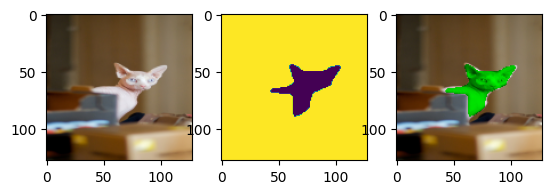

In [115]:
image = rescaled_samples["Sphynx_204"]["image"]
mask = rescaled_samples["Sphynx_204"]["mask"]
image_green = turn_green(image, mask)

fig, axes = plt.subplots(ncols = 3)
axes[0].imshow(image)
axes[1].imshow(mask)
axes[2].imshow(image_green)
fig.show()

In [116]:
images = np.array([item["image"] for item in rescaled_samples.values()])
masks = np.array([item["mask"] for item in rescaled_samples.values()])

samples_len = images.shape[0] *   images.shape[1] *  images.shape[2] 

images = images.reshape((samples_len, 3))
masks = np.where(masks.reshape((samples_len)) == 1, 1, 0) # 1 if object

In [117]:
data = {"r": images[:,0],"g": images[:,0],"b": images[:,0], "isObject": masks }
df = pd.DataFrame(data)
df.head()

,r,g,b,isObject
0,0.116635,0.116635,0.116635,0
1,0.122702,0.122702,0.122702,0
2,0.126961,0.126961,0.126961,0
3,0.136348,0.136348,0.136348,0
4,0.142191,0.142191,0.142191,0


In [118]:
df = df.sample(frac=0.01)
print(len(df))
df.head()

603914


,r,g,b,isObject
14227696,0.380451,0.380451,0.380451,0
58902922,0.694664,0.694664,0.694664,0
54184703,0.158633,0.158633,0.158633,0
24877953,0.603867,0.603867,0.603867,0
37565554,0.578495,0.578495,0.578495,1


In [119]:
X = df.drop('isObject', axis=1)
y = df["isObject"]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size = 0.4, random_state = 42, stratify = y
)

X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size = 0.25, random_state = 42, stratify = y_temp
)